Import all the required modules and libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import load_img, img_to_array
import os
import matplotlib.pyplot as plt
import pydot
from skimage import io
import numpy as np

In [2]:
np.random.seed(42)

Upload the Alzheimer's Data Set zip file from Kaggle

In [3]:
from google.colab import files
uploaded = files.upload()

Saving Alzheimer_dataset.zip to Alzheimer_dataset.zip


Unzip the file

In [4]:
import zipfile
import io
zf = zipfile.ZipFile(io.BytesIO(uploaded['Alzheimer_dataset.zip']), "r")
zf.extractall()

Set up parameters for Train vs Test split

In [73]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./Alzheimer_s Dataset/train/",
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./Alzheimer_s Dataset/train/",
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 5121 files belonging to 4 classes.
Using 1024 files for validation.


Assign class names to Train and validation sets

In [93]:
class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
train_ds.class_names = class_names
val_ds.class_names = class_names

Produce MRI images with appropriate labels

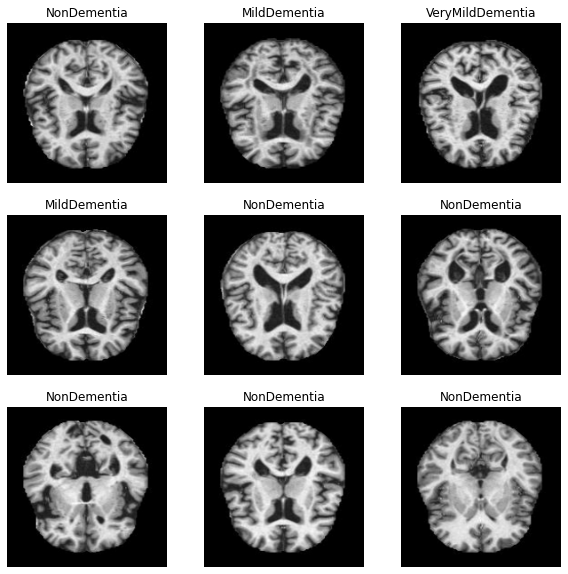

In [76]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

Generate a bar graph to analyze the distribution of the different stages

<function matplotlib.pyplot.show>

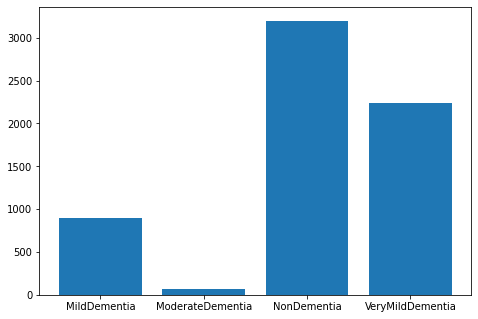

In [83]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
size = [896,64,3200,2240]
ax.bar(class_names,size)
plt.show

Create Data Augmentation

In [84]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

Run the CNN Algorithm

In [85]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 4:
        activation = "sigmoid"
        units = 4
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=4)
#keras.utils.plot_model(model, show_shapes=True)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_2 (Sequential)      (None, 180, 180, 3)  0           ['input_3[0][0]']                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 180, 180, 3)  0           ['sequential_2[0][0]']           
                                                                                                  
 conv2d_12 (Conv2D)             (None, 90, 90, 32)   896         ['rescaling_2[0][0]']      

Train the Epochs 

In [88]:
model.compile(optimizer="Adam",
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=["accuracy"])

epochs = 50
model.fit(train_ds,
          epochs=epochs,
          validation_data=val_ds, 
          batch_size=batch_size)

Epoch 1/50
129/129 [==============================] - 28s 191ms/step - loss: 1.0219 - accuracy: 0.5179 - val_loss: 1.0513 - val_accuracy: 0.5195
Epoch 2/50
129/129 [==============================] - 24s 187ms/step - loss: 0.9737 - accuracy: 0.5231 - val_loss: 1.1858 - val_accuracy: 0.5195
Epoch 3/50
129/129 [==============================] - 24s 188ms/step - loss: 0.9269 - accuracy: 0.5441 - val_loss: 1.0096 - val_accuracy: 0.5195
Epoch 4/50
129/129 [==============================] - 24s 187ms/step - loss: 0.9495 - accuracy: 0.5223 - val_loss: 0.9019 - val_accuracy: 0.5703
Epoch 5/50
129/129 [==============================] - 24s 188ms/step - loss: 0.9135 - accuracy: 0.5443 - val_loss: 1.3011 - val_accuracy: 0.2715
Epoch 6/50
129/129 [==============================] - 24s 188ms/step - loss: 0.8974 - accuracy: 0.5570 - val_loss: 0.9160 - val_accuracy: 0.4980
Epoch 7/50
129/129 [==============================] - 24s 187ms/step - loss: 0.8852 - accuracy: 0.5633 - val_loss: 0.8933 - val_ac

Plot a Confusion Matrix

In [89]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt


#Values predicted by Model
predicted_labels = []
#True Labels
true_labels = []

#Obtaining the true and predicted labels
for x,y in test_ds:
  predicted_labels.append(np.argmax(model.predict(x)))
  true_labels.append(np.argmax(y))

cm = tf.math.confusion_matrix(labels=true_labels, predictions=predicted_labels).numpy()

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



Confusion matrix, without normalization
[[ 48  43   3  85]
 [  0  12   0   0]
 [ 12  54 210 364]
 [ 11  85  15 337]]
value of cm:  [[ 48  43   3  85]
 [  0  12   0   0]
 [ 12  54 210 364]
 [ 11  85  15 337]]


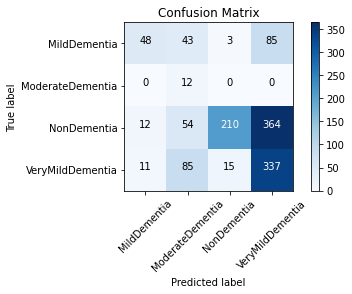

In [90]:
plot_confusion_matrix(cm=cm, classes=class_names, title='Confusion Matrix')
print('value of cm: ', cm)

Predict Images after the Train vs Test split

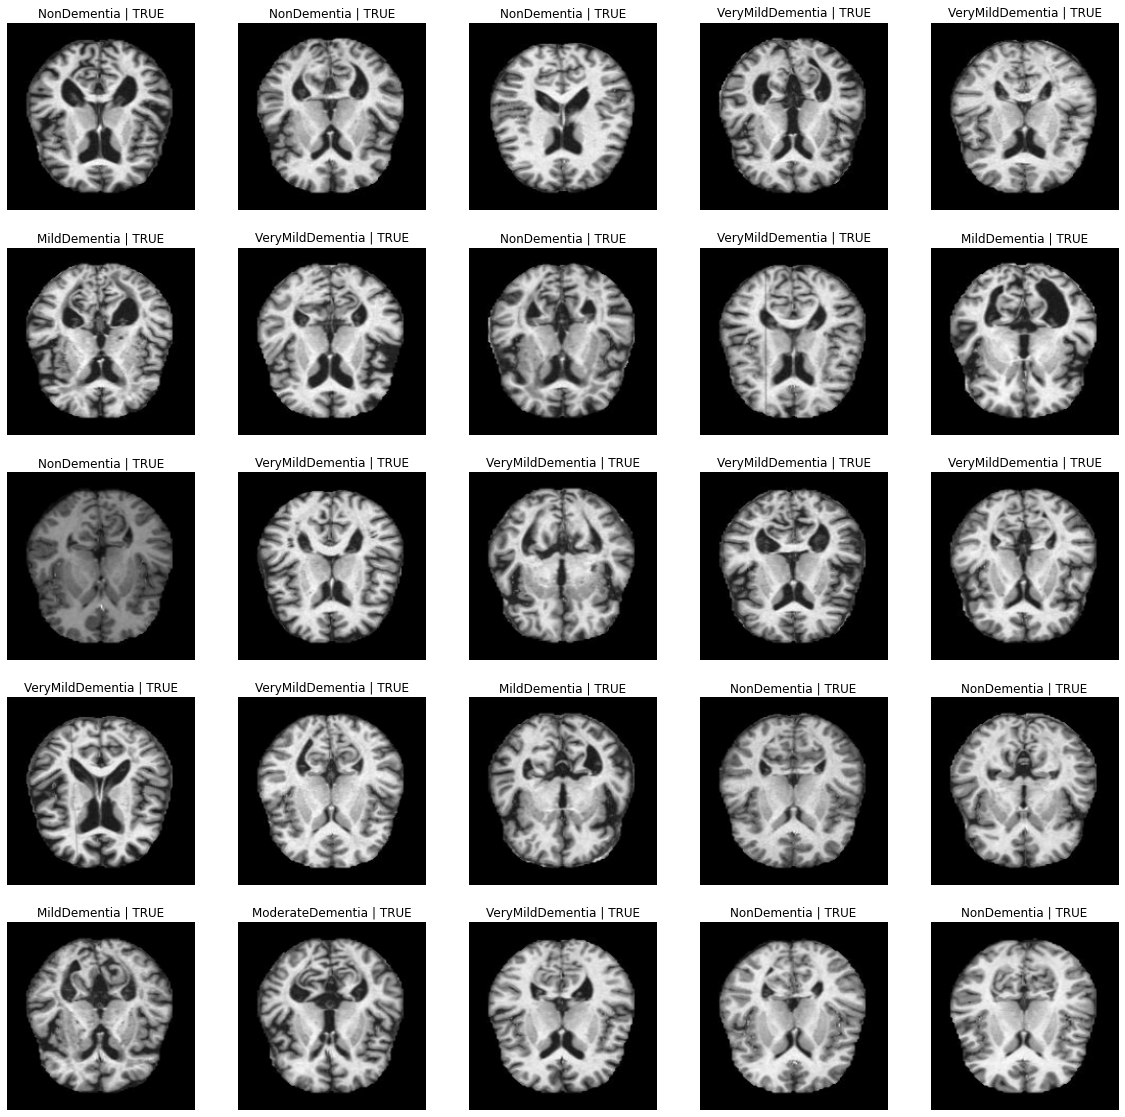

In [92]:
plt.figure(figsize=(20, 20))
result = ' | False'
for images, labels in val_ds.take(1):
    for i in range(25):
        
        ax = plt.subplot(5, 5, i + 1)
        
        img = images[i].numpy().astype("uint8")
        img = tf.expand_dims(img, axis=0)
        
        predictions = model.predict(img)
        predicted_class = np.argmax(predictions)
        if class_names[predicted_class] == class_names[labels[i]]:
            result = ' | TRUE'
            
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[predicted_class]+result  )
        plt.axis("off")